In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
train = pd.read_csv("train.csv", sep=",")
test = pd.read_csv("test.csv", sep=",")


# Data Exploration


## Basic


In [3]:
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# Columns VIP, CryoSleep have type object, convert to bool
train[["VIP", "CryoSleep"]] = train[["VIP", "CryoSleep"]].astype(bool)


In [6]:
train.describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


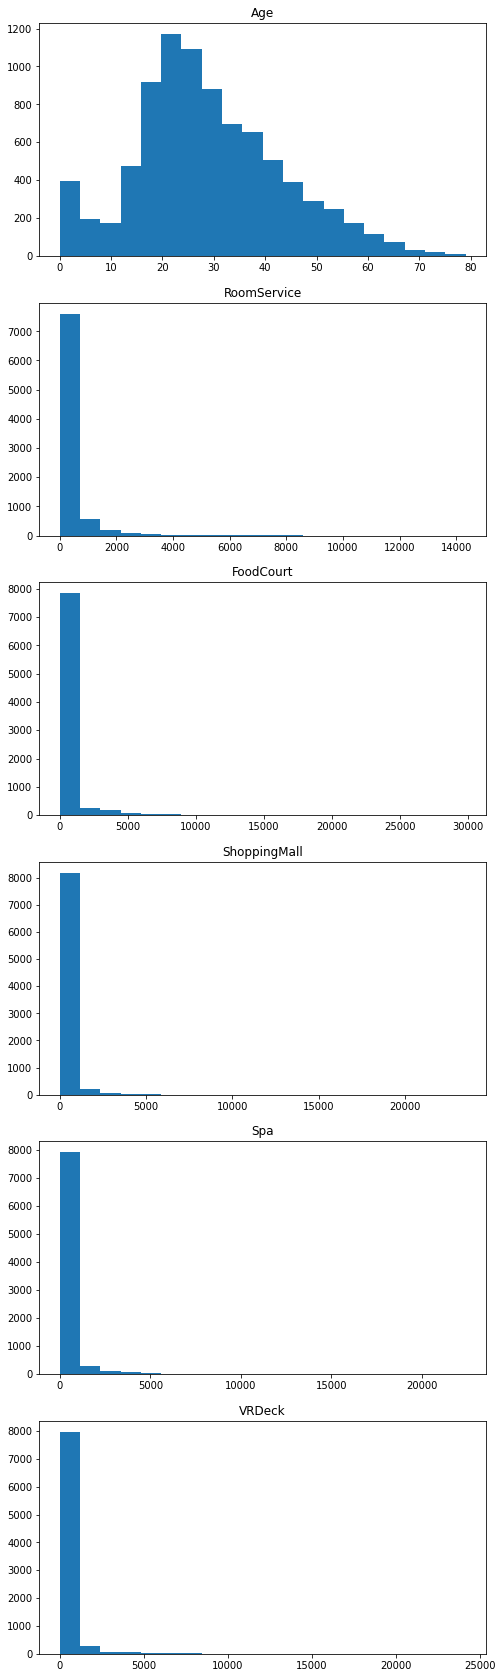

In [7]:
# Plot the distribution of all numeric columns in multiple graphs
numerical_cols = train.select_dtypes(include="number").columns
fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(8, len(numerical_cols) * 5))

for i, col in enumerate(numerical_cols):
    ax[i].hist(train[col], bins=20)
    ax[i].set_title(col)

# All columns besides age have a really uneven distribution, we will take the log1p of the value for these columns


In [8]:
for col in numerical_cols:
    if col != "Age":
        train[col] = np.log1p(train[col])


## Categorical Features transformations


In [9]:
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,Willy Santantines,True


In [58]:
# ID column to be separated between before and after the "_"
try:
    train["ID_1"], train["ID_2"] = train["PassengerId"].str.split("_").str
    train["ID_1"] = train["ID_1"].astype(int)
    train["ID_2"] = train["ID_2"].astype(int)
    train.drop("PassengerId", axis=1, inplace=True)
except KeyError:
    print("ID already split")

# Cabin column to be split into 3, separated by "/" (deck/num/side)
# We replace NaN by missing/-1/missing to signal missing cabin information
try:
    train["Cabin"] = train["Cabin"].fillna("missing/-1/missing")
    train["Cabin_deck"], train["Cabin_num"], train["Cabin_side"] = (
        train["Cabin"].str.split("/").str
    )
    train["Cabin_num"] = train["Cabin_num"].astype(int)
    train.drop("Cabin", axis=1, inplace=True)
except KeyError:
    print("Cabin already split")

# Processing of the Name column: keep only last name ?
# Drop completely because same family is probably in the same cabin ?
# For now, 2nd option
try:
    train.drop("Name", axis=1, inplace=True)
except KeyError:
    print("Name already dropped")

ID already split
Cabin already split
Name already dropped


In [59]:
object_cols = train.select_dtypes("object").columns

for col in object_cols:
    print(col, ":", train[col].nunique(), "unique values")
# few unique values: one Hot encoding is suitable


HomePlanet : 3 unique values
Destination : 3 unique values
Cabin_deck : 9 unique values
Cabin_side : 3 unique values


## Train & Validation sets


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop("Transported", axis=1),
    train["Transported"],
    test_size=0.2,
)


## Imputation


In [61]:
# look at percentage of missing values in each column
na_cols = [col for col in train.columns if train[col].isna().sum() > 0]
for col in na_cols:
    print(f"{col}: {train[col].isna().sum()/train.shape[0]*100:.2f}%")

# Around 2% missing data per column in training data


HomePlanet: 2.31%
Destination: 2.09%
Age: 2.06%
RoomService: 2.08%
FoodCourt: 2.11%
ShoppingMall: 2.39%
Spa: 2.11%
VRDeck: 2.16%


In [65]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder

# HomePlanet Imputation
od = OrdinalEncoder()
X_train["HomePlanet"] = od.fit_transform(X_train["HomePlanet"]).reshape(-1, 1)
X_valid["HomePlanet"] = od.transform(X_valid["HomePlanet"]).reshape(-1, 1)
iterative_imputer = IterativeImputer()
X_train["HomePlanet"] = iterative_imputer.fit_transform(X_train["HomePlanet"])
X_valid["HomePlanet"] = iterative_imputer.transform(X_valid["HomePlanet"])

ValueError: Expected 2D array, got 1D array instead:
array=['Earth' 'Earth' 'Earth' ... 'Europa' 'Earth' 'Europa'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [43]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,ID_1,ID_2,Cabin_deck,Cabin_num,Cabin_side
0,Europa,False,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,True,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,False,3,1,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,False,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,True,4,1,F,1,S


## One Hot Encoding


In [44]:
from sklearn.preprocessing import OneHotEncoder

label_binarizer = OneHotEncoder(sparse=False)

train_ohe_cols = pd.DataFrame(label_binarizer.fit_transform(X_train[object_cols]))
valid_ohe_cols = pd.DataFrame(label_binarizer.transform(X_valid[object_cols]))

train_ohe_cols.index = X_train.index
valid_ohe_cols.index = X_valid.index

num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

X_train_ohe = pd.concat([num_X_train, train_ohe_cols], axis=1)
X_valid_ohe = pd.concat([num_X_valid, valid_ohe_cols], axis=1)


In [15]:
X_train.shape, X_valid.shape, X_train_ohe.shape, X_valid_ohe.shape


((6954, 15), (1739, 15), (6954, 31), (1739, 31))

# Baseline model with no imputation/hyperparameter tuning


In [45]:
from xgboost import XGBClassifier

model = XGBClassifier(verbosity=0)
model.fit(X_train_ohe, y_train)


c:\Users\mlouw\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [46]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train_ohe, y_train, scoring="f1", cv=10, n_jobs=8).mean()


0.7992148902705297

In [21]:
import lightgbm as lgb

train_dataset = lgb.Dataset(X_train_ohe, label=y_train)
valid_dataset = lgb.Dataset(X_valid_ohe, label=y_valid)

In [40]:
params = {
    "objective": "binary",
    "metric": "auc",
    "min_data_in_leaf": 100,
    "num_leaves": 20,
    "n_jobs": 8,
}

model_lgb = lgb.LGBMClassifier(
    **params,
)

model_lgb.fit(X_train_ohe, y_train)

LGBMClassifier(metric='auc', min_data_in_leaf=100, n_jobs=8, num_leaves=20,
               objective='binary')

In [41]:
cross_val_score(model_lgb, X_train_ohe, y_train, scoring="f1", cv=10, n_jobs=8).mean()

0.8079488944940836

Results of models on validation set

| x                                             | xgboost | lightgbm |
| --------------------------------------------- | ------- | -------- |
| ~no parameter tuning </br> no data imputation | 0.799   | 0.808    |
| no parameter tuning </br> data imputation     |         |          |
| parameter tuning </br> data imputation        |         |          |
